# 数据同化用于参数估计

> 海洋学院，沈浙奇，2024年6月， zqshen@hhu.edu.cn

在前面的例子中，我们采用了一种比较理想的情况来进行数据同化，即模式是完美的，误差只来自于初值。我们使用准确的模式参数进行数值积分，通过观测数据来减少初值造成的误差，达成有效的预报。

现实中，误差还可能来自于不良的参数。假设，我们仍然用Lorenz63模式来造真值和观测，只不过在实际模式积分的时候，我们选择不一样的参数，那么会有什么结果呢？

$$\frac{dx}{dt}=\sigma(y-x) \qquad (1)$$
$$\frac{dy}{dt}=\rho x-y-xz \qquad (2)$$
$$\frac{dz}{dt}=xy-\beta z \qquad (3)$$

仍然使用实验代码来说明问题，定义模式和造观测的部分照旧。

In [1]:
# 定义模式方程和积分格式
import numpy as np
def Lorenz63(state,*args):       #Lorenz63模式
    sigma = args[0]
    beta = args[1]
    rho = args[2]
    x, y, z = state 
    f = np.zeros(3) 
    f[0] = sigma * (y - x)
    f[1] = x * (rho - z) - y
    f[2] = x * y - beta * z
    return f 
def RK4(rhs,state,dt,*args):    # Runge-Kutta格式，输入的rhs代表模式右端方程
    k1 = rhs(state,*args)
    k2 = rhs(state+k1*dt/2,*args)
    k3 = rhs(state+k2*dt/2,*args)
    k4 = rhs(state+k3*dt,*args) # 输出新的一步的状态
    new_state = state + (dt/6)*(k1+2*k2+2*k3+k4)
    return new_state

# 之后使用 RK4(Lorenz63,x_in,dt,sigma,beta,rho)可以进行步长为dt的一步积分

In [2]:
# Lorenz63模式真值试验和观测构造
sigma = 10.0; beta = 8.0/3.0; rho = 28.0          # 模式参数值   
dt = 0.01                                         # 模式积分步长
n = 3                                             # 模式的状态维数，即有多少个状态变量
m = 3                                             # 模式的观测维数，即多少个变量可以被观测到，这里先假定所有变量都能被观测
tm = 10                                           # 同化试验时间窗口
nt = int(tm/dt)                                   # 总积分步数
t = np.linspace(0,tm,nt+1)                        # 模式时间网格
x0True = np.array([1.508870, -1.531271, 25.46091])# 真实值的初值
np.random.seed(seed=1)              # 设置随机种子，由于电脑的随机数是伪随机，记录了随机种子之后，每次运行这个脚本产生的“随机”的观测误差都是一样的。
sig_m= 0.5                                        # 观测误差标准差
R = sig_m**2*np.eye(n)                            # 观测误差协方差矩阵，设为对角阵使得不同变量的误差互不相干
dt_m = 0.2                                        # 观测之间的时间间隔（即每20模式步观测一次）
tm_m = 10                                         # 最大观测时间（即多少时间之后停止同化，可小于同化试验时间窗口）
nt_m = int(tm_m/dt_m)                             # 进行同化的总次数
ind_m = (np.linspace(int(dt_m/dt),int(tm_m/dt),nt_m)).astype(int)   # 这是有观测的时刻在总时间网格中的位置指标
t_m = t[ind_m]                                                      # 观测网格
def h(x):                                         # 定义观测算子：观测算子用于构建模式变量和观测之间的关系。当所有变量被观测时，使用单位阵。
    H = np.eye(n)                                 # 观测矩阵为单位阵。
    yo = H@x                                      # 单位阵乘以状态变量，即所有变量直接被观测。
    return yo
Xtrue = np.zeros([n,nt+1])                        # 真值保存在xTrue变量中
Xtrue[:,0] = x0True                               # 初始化真值
km = 0                                            # 观测计数
yo = np.zeros([3,nt_m])                           # 观测保存在yo变量中
for k in range(nt):                               # 按模式时间网格开展模式积分循环
    Xtrue[:,k+1] = RK4(Lorenz63,Xtrue[:,k],dt,sigma,beta,rho)       # 真实值积分
    if (km<nt_m) and (k+1==ind_m[km]):                              # 用指标判断是否进行观测
        yo[:,km] = h(Xtrue[:,k+1]) + np.random.normal(0,sig_m,[3,]) # 通过判断，在观测时间取出真值作为观测值，同时叠加高斯分布随机噪声
        km = km+1                                                   # 观测计数，用于循环控制
        
# 这个脚本产生了同化实验中的观测数据yo和用于对比结果的真值Xtrue。

接下来，我们要开展同化实验。采用sEAKF的算法如下。同化的代码和之前完全相同，只不过是使用了有偏的参数。

In [3]:
#%% （串行）集合调整卡尔曼滤波器
def obs_increment_eakf(ensemble, observation, obs_error_var): # 1：计算观测空间增量
    prior_mean = np.mean(ensemble);
    prior_var = np.var(ensemble);
    if prior_var >1e-6:                                                 # 用于避免退化的先验集合造成错误更新
        post_var = 1.0 / (1.0 / prior_var + 1.0 / obs_error_var);       # 公式（2）
        post_mean = post_var * (prior_mean / prior_var + observation / obs_error_var);  # 公式（3）
    else:
        post_var = prior_var; post_mean = prior_mean;    
    updated_ensemble = ensemble - prior_mean + post_mean;
    var_ratio = post_var / prior_var;
    updated_ensemble = np.sqrt(var_ratio) * (updated_ensemble - post_mean) + post_mean; # 公式（4）
    obs_increments = updated_ensemble - ensemble;
    return obs_increments
def get_state_increments(state_ens, obs_ens, obs_incs): # 2将观测增量回归到状态增量
    covar = np.cov(state_ens, obs_ens);
    state_incs = obs_incs * covar[0,1]/covar[1,1];
    return state_incs
def sEAKF(xai,yo,ObsOp, R, RhoM):
    n,N = xai.shape;                  # 状态维数
    m = yo.shape[0];                  # 观测数
    Loc = ObsOp(RhoM)                 # 观测空间局地化
    for i in range(m):                # 针对每个标量观测的循环
        hx = ObsOp(xai);              # 投影到观测空间 
        hxi = hx[i];                  # 投影到对应的矢量观测
        obs_inc = obs_increment_eakf(hxi,yo[i],R[i,i]);
        for j in range(n):            # 针对状态变量的每个元素的循环
            state_inc = get_state_increments(xai[j], hxi,obs_inc)   # 获取状态增量
            cov_factor=Loc[i,j]       # 使用局地化矩阵的相应元素
            if cov_factor>1e-6:       # 在局地化范围内加增量
                xai[j]=xai[j]+cov_factor*state_inc; 
    return xai

In [4]:
#!!!!!!!!!!!!!!!!!!! 使用有偏差的参数开展试验
sigma = 13 ; beta = 3; rho = 30       # 注意参数的真值分别是10,8/3和28
# 剩下的同化部分和前面一致

# EAKF同化实验流程
x0b = np.array([1,-1,20])                # 背景积分的初值
Xb = np.zeros([3,nt+1]); Xb[:,0] = x0b   # 控制试验结果存在xb中
# --------------- 背景积分实验 ------------------------
for k in range(nt):                      # 模式积分循环
    Xb[:,k+1] = RK4(Lorenz63,Xb[:,k],dt,sigma,beta,rho)   # 不加同化的背景积分结果，后面和同化结果进行对比
# --------------- 数据同化实验 ------------------------
sig_b= 1.0                               # 设定初始的背景误差
B = sig_b**2*np.eye(3)                   # 设定初始背景误差协方差矩阵，B矩阵的取值对于变分同化比较重要，这个简单模式可以使用简单的对角阵

N = 20                                   # 设定集合成员数
xai = np.zeros([3,N])                    # 设定集合，保存在 xai 中
for i in range(N):
    xai[:,i] = x0b + np.random.multivariate_normal(np.zeros(n), B)    # 通过对预报初值进行随机扰动构造初始集合

Xa = np.zeros([3,nt+1]); Xa[:,0] = x0b   # 同化试验结果存在Xa中，第一步没同化，所以数值也是x0b
km = 0                                   # 同化次数计数
H = np.eye(3)                            # 如前述，观测算子是单位阵
for k in range(nt):                      # 模式积分循环
    for i in range(N):                   # 对每个集合成员积分
        xai[:,i] = RK4(Lorenz63,xai[:,i],dt,sigma,beta,rho) 
    if (km<nt_m) and (k+1==ind_m[km]):   # 当有观测时
        xai = sEAKF(xai,yo[:,km],h,R,np.ones([3,3]))  # 调用 sEASKF 同化
        km = km+1
    Xa[:,k+1] = np.mean(xai,1)           # 非同化时刻求预报平均，同化时刻求分析平均

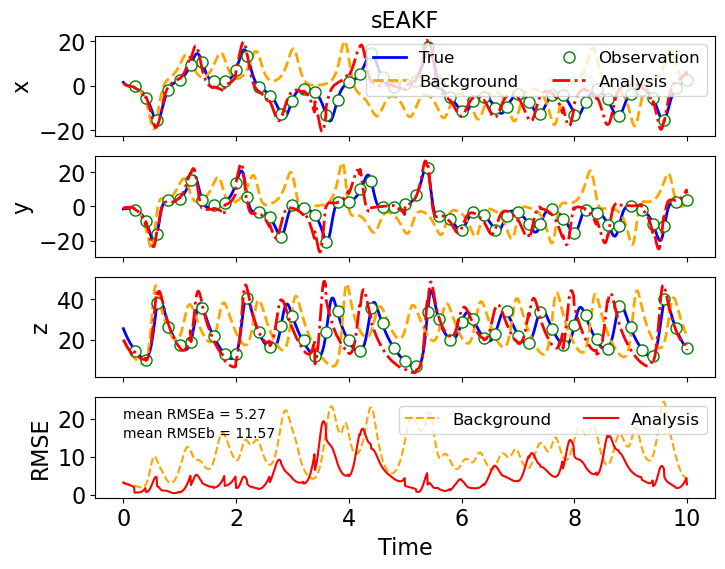

In [5]:
RMSEb = np.sqrt(np.mean((Xb-Xtrue)**2,0))
RMSEa = np.sqrt(np.mean((Xa-Xtrue)**2,0))
# 结果画图
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
lbs = ['x','y','z']
for j in range(3):
    plt.subplot(4,1,j+1)
    plt.plot(t,Xtrue[j],'b-',lw=2,label='True')
    plt.plot(t,Xb[j],'--',color='orange',lw=2,label='Background')
    plt.plot(t_m,yo[j],'go',ms=8,markerfacecolor='white',label='Observation')
    plt.plot(t,Xa[j],'-.',color='red',lw=2,label='Analysis')
    plt.ylabel(lbs[j],fontsize=16)
    plt.xticks(np.arange(0,10.1,2),[]);plt.yticks(fontsize=16)
    if j==0:
        plt.legend(ncol=2, loc='upper right',fontsize=12)
        plt.title("sEAKF",fontsize=16)     #!!!!!!!!!!!!!!!!!!!!!!!!!!!
plt.subplot(4,1,4)
plt.plot(t,RMSEb,'--',color='orange',label='Background')
plt.plot(t,RMSEa,color='red',label='Analysis')
plt.text(0,15,'mean RMSEb = %0.2f' %np.mean(RMSEb))
plt.text(0,20,'mean RMSEa = %0.2f' %np.mean(RMSEa))
plt.ylabel('RMSE',fontsize=16)
plt.xlabel('Time',fontsize=16)
plt.xticks(fontsize=16);plt.yticks(fontsize=16)
plt.legend(ncol=2, loc='upper right',fontsize=12)

看图说话，同化相比于背景积分仍然是有效果的。但是，由于实际积分使用的模式和真值模式的参数差异很大，导致两次同化之间的模式积分就会产生很大误差，同化的效果实际上没那么显著，最后的分析效果也只能说是差强人意。

那么，有没有可能通过数据同化来调整参数呢？

*这个是可行的！*

做法就是把参数也当成是某个状态变量，利用卡尔曼滤波器构建的跨变量之间的相关，用有观测的状态变量调整没有观测的参数。

在这种情况下，3个状态变量($x,y,z$)加上3个参数($\sigma,\rho,\beta$)的总维数是6（我们把两者合起来的6变量的向量称为“扩展状态向量”），而观测到的是3个变量，所以需要先构造观测算子，把扩展状态向量投影到$x,y,z$的观测。

In [6]:
def hp(x):                # 扩展观测算子
    ne= x.shape[0]        # 输入的 x 包括状态和参数:ne=n+ns  
    H = np.eye(ne)
    Hs = H[range(n),:]
    yo = Hs @ x           #投影到状态变量
    return yo

同化实验中，除了要做状态的集合，也要做参数的集合，同化的时候用扩展状态向量集合进行sEAKF的同化，积分的时候每个集合成员也都使用不同的初值和不同的参数进行积分。提供代码如下：

In [7]:
npara = 3                # !!!!!!!!!! 待估参数数目

x0b = np.array([1,-1,20])                # 背景积分的初值
Xb = np.zeros([3,nt+1]); Xb[:,0] = x0b   # 控制试验结果存在xb中
# --------------- 背景积分实验 ------------------------
for k in range(nt):                      # 模式积分循环
    Xb[:,k+1] = RK4(Lorenz63,Xb[:,k],dt,sigma,beta,rho)   # 不加同化的背景积分结果，后面和同化结果进行对比
# --------------- 数据同化实验 ------------------------
sig_b= 1.0                               # 设定初始的背景误差
B = sig_b**2*np.eye(3)                   # 设定初始背景误差协方差矩阵，B矩阵的取值对于变分同化比较重要，这个简单模式可以使用简单的对角阵

N = 20                                   # 设定集合成员数
xai = np.zeros([3,N])                    # 设定集合，保存在 xai 中
for i in range(N):
    xai[:,i] = x0b + np.random.multivariate_normal(np.zeros(n), B)    # 通过对预报初值进行随机扰动构造初始集合
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! 这里做参数集合
p0b = np.array([sigma,beta,rho])                        # 参数向量
sig_p = np.array([4,4,4])
pB = np.diag(sig_p)                                     # 参数误差协方差
pai = np.zeros([npara,N])                               # 参数集合
for i in range(N):
    pai[:,i] = p0b + np.random.multivariate_normal(np.zeros(npara), pB)
    
Rp = np.diag(np.concatenate([sig_m*np.ones(n),sig_p]))  # 扩展误差协方差: 拼接B和pB
LocM = np.ones([n+npara,n+npara])                       # 局地化相关的部分，仍然简单使用所有元素设置为1的矩阵
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

Xa = np.zeros([n,nt+1]); Xa[:,0] = x0b   
Pa = np.zeros([npara,nt+1]); Pa[:,0] = p0b              # !!!!!!!!!!!! 保存参数分析值
km = 0
for k in range(nt):
    for i in range(N):
        xai[:,i] = RK4(Lorenz63,xai[:,i],dt,pai[0,i],pai[1,i],pai[2,i])    # !!!!!!!!每个集合成员用它自己的参数积分

    Xa[:,k+1] = np.mean(xai,1)    # 预报集合平均状态
    Pa[:,k+1] = np.mean(pai,1)    # !!!!!!!!!!预报集合平均参数
    if (km<nt_m) and (k+1==ind_m[km]):
        # !!!!!!!!!!!!扩展向量并进行同化       
        xAi = np.concatenate([xai,pai],axis=0)        
        xAi= sEAKF(xAi,yo[:,km],hp,Rp,LocM)
        # !!!!!!!!!!!!
        xai = xAi[0:3,:]
        pai = xAi[3:6,:]          #!!!!!!!!!!! 参数分析集合
        Xa[:,k+1] = np.mean(xai,1)
        Pa[:,k+1] = np.mean(pai,1)#!!!!!!!!!!! 参数分析值（集合平均）
        km = km+1

这整个实验的代码改动量也不能算很大，主要的思想是在同化的时候把参数也同时更新。为此需要构造参数集合，然后把观测作为是针对扩展向量的观测。这样，参数和状态变量之间的相关也会纳入考虑。

接下来，我们在画图的时候主要看状态变量的RMSE和参数平均值的演变过程：

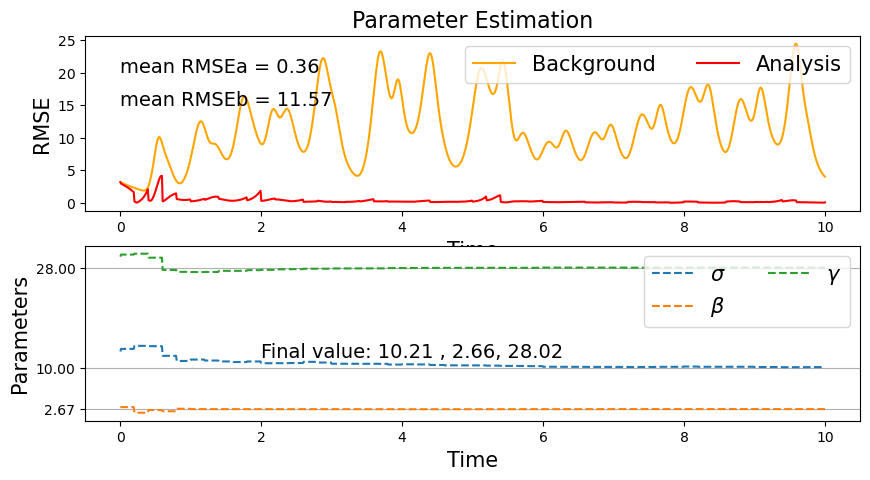

In [8]:
#%% 参数估计画图        
plt.figure(figsize=(10,5))
plt.subplot(2,1,1)       
RMSEb = np.sqrt(np.mean((Xb-Xtrue)**2,0))
RMSEa = np.sqrt(np.mean((Xa-Xtrue)**2,0))
plt.plot(t,RMSEb,color='orange',label='Background')
plt.plot(t,RMSEa,color='red',label='Analysis')
plt.text(0,15,'mean RMSEb = %0.2f' %np.mean(RMSEb),fontsize=14)
plt.text(0,20,'mean RMSEa = %0.2f' %np.mean(RMSEa),fontsize=14)
plt.ylabel('RMSE',fontsize=15)
plt.xlabel('Time',fontsize=15)
plt.legend(ncol=2, loc='upper right',fontsize=15)
plt.title("Parameter Estimation",fontsize=16)
plt.subplot(2,1,2)
plt.plot(t,Pa[0,:],'--',label=r'$\sigma$')
plt.plot(t,Pa[1,:],'--',label=r'$\beta$')
plt.plot(t,Pa[2,:],'--',label=r'$\gamma$')
plt.ylabel('Parameters',fontsize=15)
plt.xlabel('Time',fontsize=15)
plt.text(2,12,'Final value: %0.2f '%Pa[0,-1]+', %0.2f'%Pa[1,-1]+', %0.2f'%Pa[2,-1],fontsize=14)
plt.yticks([8/3,10,28])
plt.grid(axis='y')
plt.legend(ncol=2, loc='upper right',fontsize=15)

我们看到了参数是怎么被调整过来的。而且由于参数能够被纠正过来，模式的预报误差变小了，从而RMSE也显著降低。

仔细想想，我们会发现EnKF及衍生方法才能做这样的参数估计，而3D-Var不行，因为很难客观给出参数的背景误差协方差矩阵。此外，参数估计过程中，其实参数的不确定性是不断降低的，如果同化方法没有流依赖性不能及时反映这点的话，也会导致参数被调整过头的现象。而EKF，本身使用切线模型已经会带来很大的误差了，如果进一步开发包括参数不确定性的切线模型，这个难度也是极大且效果不佳的。

## 总结

这里只给一个简单的例子说明上述的“扩展状态空间”的参数估计思想，也就是把参数作为特殊的无法直接观测的状态变量，用观测进行调整。

实际大型模式中的参数估计从原理上说也是这么做的，只不过还有很多的技术细节，是值得进一步研究和应用的。